![Kaggle Days Paris](https://kaggledays.com/wp-content/uploads/sites/2/2018/11/46508555_1939772529664297_1579296553191866368_n-1024x536.png)

# Competitive GBDT Specification and Optimization Workshop


## Instructors
* Luca Massaron [@lmassaron](https://www.linkedin.com/in/lmassaron/) - Data Scientist / Author / Google Developer Expert in Machine Learning 
* Pietro Marinelli [@pietro-marinelli-0098b427](https://www.linkedin.com/in/pietro-marinelli-0098b427/) - Freelance Data Scientist

## About the workshop

Gradient Boosting Decision Trees (GBDT) presently represent the state of the art for building predictors for flat table data. However, they seldom perform the best out-of-the-box (using default values) because of the many hyper-parameters to tune. Especially in the most recent GBDT implementations, such as LightGBM, the over-sophistication of hyper-parameters renders finding the optimal settings by hand or simple grid search difficult because of high combinatorial complexity and long running times for experiments. 

[Random Optimization](https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf) (BERGSTRA, James; BENGIO, Yoshua. Random search for hyper-parameter optimization. Journal of Machine Learning Research, 2012, 13.Feb: 281-305.) and [Bayesian Optimization](https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf) (SNOEK, Jasper; LAROCHELLE, Hugo; ADAMS, Ryan P. Practical bayesian optimization of machine learning algorithms. In: Advances in neural information processing systems. 2012. p. 2951-2959) are often the answer you'll find from experts.

In this workshop we demonstrate how to use different optimization approaches based on [Scikit-Optimize](https://github.com/scikit-optimize/scikit-optimize), a library built on top of NumPy, SciPy and Scikit-Learn, and we present an easy and fast approach to set them ready and usable.

## Prerequisites

You should be aware of the role and importance of hyper-parameter optimization in machine learning.  

## Obtaining the Tutorial Material
In order to make the workshop easily accessible, we are offering cloud access:
* Using [Google Colab](https://colab.research.google.com/github/lmassaron/kaggledays-2019-gbdt/blob/master/Kaggle%20Days%20Paris%20-%20%20GBDT%20workshop.ipynb) 
* Using [Kaggle Kernels]()

We also have a brief exercise that can be found at:
* Using [Google Colab](https://colab.research.google.com/github/lmassaron/kaggledays-2019-gbdt/blob/master/Kaggle%20Days%20Paris%20-%20Skopt%20%2B%20CatBoost%20exercise.ipynb)
* Using [Kaggle Kernels]()

The solution can be found [here](https://github.com/lmassaron/kaggledays-2019-gbdt/blob/master/Kaggle%20Days%20Paris%20-%20Skopt%20%2B%20CatBoost%20solution.ipynb).

All the materials can be cloned from Github at the [kaggledays-2019-gbdt](https://github.com/lmassaron/kaggledays-2019-gbdt) repository.
We also have prepared a stand-alone Windows installation using WinPython.

## Local installation notes

In order to successfully run this workshop on your local computer, you need a Python3 installation (we suggest installing the most recent [Anaconda](https://www.anaconda.com/download/) distribution) and at least the following packages:

* numpy >= 1.15.4
* pandas >= 0.23.4
* scipy >= 1.1.0
* skopt >= 0.5.2
* sklearn >= 0.20.2
* lightgbm >= 2.2.2
* xgboost >= 0.81
* catboost >= 0.12.2


# PART I : Specifying models

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Gradient Boosting
import lightgbm as lgb

# Scikit-learn
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold 
from sklearn.preprocessing import PolynomialFeatures

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_boston

In [2]:
# Uploading the Boston dataset
X, y = load_boston(return_X_y=True)

# Transforming the problem into a classification (unbalanced)
y_bin = (y > np.percentile(y, 90)).astype(int)

In [3]:
#CRIM - per capita crime rate by town
#ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
#INDUS - proportion of non-retail business acres per town.
#CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
#NOX - nitric oxides concentration (parts per 10 million)
#RM - average number of rooms per dwelling
#AGE - proportion of owner-occupied units built prior to 1940
#DIS - weighted distances to five Boston employment centres
#RAD - index of accessibility to radial highways
#TAX - full-value property-tax rate per $10,000
#PTRATIO - pupil-teacher ratio by town
#B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
#LSTAT - % lower status of the population
#MEDV - Median value of owner-occupied homes in $1000's this is our target variable

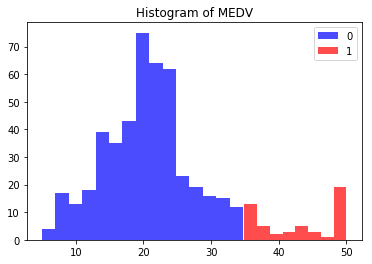

In [44]:
# Histogram highlighting the top 10% we use as a target
plt.hist(y[y <= np.percentile(y, 90)], bins='auto', alpha=0.7, label='0', color='b')
plt.hist(y[y > np.percentile(y, 90)], bins=8, alpha=0.7, label='1', color='r')
plt.title("Histogram of MEDV")
plt.legend(loc='upper right')
plt.show()

In [5]:
train = pd.DataFrame(X)

In [6]:
print(train.shape)

(506, 13)


In [7]:
K = 5
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=8)

In [8]:
MAX_ROUNDS = 1200
OPTIMIZE_ROUNDS = True
LEARNING_RATE = 0.06
iterations = []
final_score = []

In [9]:
# Set up the classifier
params = {
    'learning_rate': LEARNING_RATE, 
    'max_depth': 6, 
    #'lambda_l1': 16.7,
    'min_data_in_leaf':5,
    'boosting': 'gbdt', 
    'objective': 'binary', 
    'metric': 'auc',
    'feature_fraction': .9,
    'is_training_metric': False, 
    'seed': 1
}

In [11]:
for i, (train_index, test_index) in enumerate(kf.split(train,y_bin)):
    
    # Create data for this fold
    y_train, y_valid = y_bin[train_index], y_bin[test_index]
    X_train, X_valid = train.iloc[train_index,:], train.iloc[test_index,:]
        
    print( "\nFold ", i)

    # Run model for this fold

    fit_model = lgb.train(params, 
                          lgb.Dataset(X_train, label=y_train), 
                          MAX_ROUNDS, 
                          lgb.Dataset(X_valid, label=y_valid), 
                          verbose_eval=10, 
                          #feval= auc, 
                          early_stopping_rounds=50)
    
    print( " Best iteration = ", fit_model.best_iteration)
    
    iterations = np.append(iterations, fit_model.best_iteration)
    final_score = np.append(final_score, fit_model.best_score['valid_0']['auc'])
    pred = fit_model.predict(X_valid, num_iteration=fit_model.best_iteration)


Fold  0
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's auc: 0.966034
[20]	valid_0's auc: 0.968032
[30]	valid_0's auc: 0.968032
[40]	valid_0's auc: 0.965035
[50]	valid_0's auc: 0.964036
[60]	valid_0's auc: 0.962038
Early stopping, best iteration is:
[12]	valid_0's auc: 0.97003
 Best iteration =  12

Fold  1
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's auc: 0.817582
[20]	valid_0's auc: 0.963736
[30]	valid_0's auc: 0.959341
[40]	valid_0's auc: 0.963736
[50]	valid_0's auc: 0.967033
[60]	valid_0's auc: 0.973626
[70]	valid_0's auc: 0.974725
[80]	valid_0's auc: 0.974725
[90]	valid_0's auc: 0.973626
[100]	valid_0's auc: 0.973626
[110]	valid_0's auc: 0.974725
Early stopping, best iteration is:
[64]	valid_0's auc: 0.974725
 Best iteration =  64

Fold  2
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's auc: 0.974725
[20]	valid_0's auc: 0.975824
[30]	valid_0's auc: 0.976923
[40]	valid_0's auc: 0.979121
[50]	

In [12]:
print(iterations)
iterations_for_luca = np.mean(iterations)
print(iterations_for_luca)

[ 12.  64. 118.   5.  15.]
42.8


In [13]:
print(final_score)
final_score = np.mean(final_score)
print(final_score)

[0.97002997 0.97472527 0.98901099 1.         0.98901099]
0.9845554445554445


In [14]:
poly = PolynomialFeatures(2)
poly_train = poly.fit_transform(train)

In [15]:
poly_train = pd.DataFrame(poly_train)

In [16]:
poly_train.head()

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,1.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,...,87616.0,4528.8,117482.40,1474.08,234.09,6072.570,76.194,157529.6100,1976.5620,24.8004
1,1.0,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,...,58564.0,4307.6,96049.80,2211.88,316.84,7064.820,162.692,157529.6100,3627.6660,83.5396
2,1.0,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,...,58564.0,4307.6,95064.86,975.26,316.84,6992.374,71.734,154315.4089,1583.1049,16.2409
3,1.0,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,...,49284.0,4151.4,87607.86,652.68,349.69,7379.581,54.978,155732.8369,1160.2122,8.6436
4,1.0,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,...,49284.0,4151.4,88111.80,1183.26,349.69,7422.030,99.671,157529.6100,2115.4770,28.4089


In [17]:
poly_train = poly_train.add_prefix('poly_')

In [18]:
train = pd.concat([train,poly_train], axis=1)

In [19]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,poly_95,poly_96,poly_97,poly_98,poly_99,poly_100,poly_101,poly_102,poly_103,poly_104
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,...,87616.0,4528.8,117482.40,1474.08,234.09,6072.570,76.194,157529.6100,1976.5620,24.8004
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,...,58564.0,4307.6,96049.80,2211.88,316.84,7064.820,162.692,157529.6100,3627.6660,83.5396
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,...,58564.0,4307.6,95064.86,975.26,316.84,6992.374,71.734,154315.4089,1583.1049,16.2409
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,...,49284.0,4151.4,87607.86,652.68,349.69,7379.581,54.978,155732.8369,1160.2122,8.6436
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,...,49284.0,4151.4,88111.80,1183.26,349.69,7422.030,99.671,157529.6100,2115.4770,28.4089


In [20]:
MAX_ROUNDS = 1200
OPTIMIZE_ROUNDS = True
LEARNING_RATE = 0.06
iterations = []
final_score = []

In [21]:
# Set up classifier
params = {
    'learning_rate': LEARNING_RATE, 
    'max_depth': 12, 
    #'lambda_l1': 16.7,
    'min_data_in_leaf':10,
    'boosting': 'gbdt', 
    'objective': 'binary', 
    'metric': 'auc',
    'feature_fraction': .9,
    'is_training_metric': False, 
    'seed': 1
}

In [22]:
for i, (train_index, test_index) in enumerate(kf.split(train,y_bin)):
    
    # Create data for this fold
    y_train, y_valid = y_bin[train_index], y_bin[test_index]
    X_train, X_valid = train.iloc[train_index,:], train.iloc[test_index,:]
    #test = test_df.copy()[col]
    print( "\nFold ", i)

    # Run model for this fold

    fit_model = lgb.train( 
                               params, 
                               lgb.Dataset(X_train, label=y_train), 
                               MAX_ROUNDS, 
                               lgb.Dataset(X_valid, label=y_valid), 
                               verbose_eval=10, 
                               #feval= auc, 
                               early_stopping_rounds=50 
                             )
    print( " Best iteration = ", fit_model.best_iteration )
    iterations = np.append(iterations,fit_model.best_iteration)
    final_score = np.append(final_score, fit_model.best_score['valid_0']['auc'])
    pred = fit_model.predict(X_valid, num_iteration=fit_model.best_iteration)
        #test_pred = fit_model.predict(test[col], num_iteration=fit_model.best_iteration)


Fold  0
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's auc: 0.929071
[20]	valid_0's auc: 0.946054
[30]	valid_0's auc: 0.957043
[40]	valid_0's auc: 0.962038
[50]	valid_0's auc: 0.959041
[60]	valid_0's auc: 0.962038
[70]	valid_0's auc: 0.965035
[80]	valid_0's auc: 0.968032
[90]	valid_0's auc: 0.969031
[100]	valid_0's auc: 0.974026
[110]	valid_0's auc: 0.975025
[120]	valid_0's auc: 0.97003
[130]	valid_0's auc: 0.971029
[140]	valid_0's auc: 0.971029
[150]	valid_0's auc: 0.971029
Early stopping, best iteration is:
[108]	valid_0's auc: 0.975025
 Best iteration =  108

Fold  1
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's auc: 0.946154
[20]	valid_0's auc: 0.945055
[30]	valid_0's auc: 0.968132
[40]	valid_0's auc: 0.963736
[50]	valid_0's auc: 0.971429
[60]	valid_0's auc: 0.97033
[70]	valid_0's auc: 0.97033
[80]	valid_0's auc: 0.974725
[90]	valid_0's auc: 0.975824
[100]	valid_0's auc: 0.972527
[110]	valid_0's auc: 0.973626
[120]	valid

In [23]:
print(iterations)
iterations_for_luca = np.mean(iterations)
print(iterations_for_luca)

[108.  83.   4.  10.  16.]
44.2


In [24]:
print(final_score)
final_score = np.mean(final_score)
print(final_score)

[0.97502498 0.98131868 0.9978022  1.         0.98571429]
0.987972027972028


similar score and similar number of rounds but more features so my suggestion for Luca is that we have to rely on the basic dataset and use a number of iterations equal to 30

# PART II : Optimizing hyper-parameters

The topic of this workshop is also to illustrate how to best optimize the hyperparameters of a gradient boosting model (lightGBM before all, but also XGBoost and CatBoost) in a performing and efficient way. We will also compare the strong and weak points of different tuning approaches, such grid-search, random search and bayesian optimization by Scikit-optimize.

Leaving apart grid-search (feasible only when the space of experiments is limited), the usual choice for the practitioner is to apply random search optimization or try some [Bayesian Optimization](https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf) (BO) technique, which require a more complex setup. 

As for as BO, there are quite a few choices (for instance Hyperopt) but we decided for Scikit-Optimize, or skopt, because it is a simple and efficient library to minimize (very) expensive and noisy black-box functions and it works with an API similar to Scikit-learn. It can be found at https://github.com/scikit-optimize/scikit-optimize/

In [1]:
# Installing the most recent version of skopt directly from Github
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

  Cloning https://github.com/scikit-optimize/scikit-optimize.git to c:\users\luca\appdata\local\temp\pip-req-build-oglms7e5
  Running setup.py bdist_wheel for scikit-optimize: started
  Running setup.py bdist_wheel for scikit-optimize: finished with status 'done'
  Stored in directory: C:\Users\Luca\AppData\Local\Temp\pip-ephem-wheel-cache-fr8qpg45\wheels\11\6f\86\2b772172db85ad0b4487d67e325e535ee8e7782b2a1dfcadf5
Successfully built scikit-optimize


In [2]:
# Assuring you have the most recent CatBoost release
!pip install catboost -U

Requirement already up-to-date: catboost in c:\users\luca\anaconda3\lib\site-packages (0.12.2)


In [3]:
# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Our example dataset
from sklearn.datasets import load_boston

# Classifiers
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Hyperparameters distributions
from scipy.stats import randint
from scipy.stats import uniform

# Model selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args # decorator to convert a list of parameters to named arguments
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import VerboseCallback # Callback to control the verbosity
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which the objective has been evaluated are less than delta

Optimizing hyper-parameters requires time and resources. In order to speed up the demonstration we will be using a toy dataset, the Boston Houseprice dataset for a classification task, to predicted the top 10% most expensive houses.

The dataset presents information collected by the U.S Census Service concerning housing proces and conditions in the area of Boston Mass. Originally found in the [StatLib archive](http://lib.stat.cmu.edu/datasets/boston), the dataset has been used extensively throughout the literature to benchmark machine learning algorithms. The data was originally published by :
> Harrison, D. and Rubinfeld, D.L. Hedonic prices and the demand for clean air', J. Environ. Economics & Management, vol.5, 81-102, 1978.

The dataset contains 14 variabile relative to 506 house that were sold in the suburbs of Boston. Among the variables, the 14th, MEDV - Median value of owner-occupied homes in $1000's - is commonly used as a target for regression problems. In our example we will use it for classification, after binarizing it at the 90th percentile (also creating an unbalanced classification problem, since the positive cases are just 10 percent of the total). 

In [4]:
# Uploading the Boston dataset
X, y = load_boston(return_X_y=True)

In [5]:
# Transforming the problem into a classification (unbalanced)
y_bin = (y > np.percentile(y, 90)).astype(int)

# Optimizing Scikit-learn GradientBoostingClassifier

GridSearchCV, RandomizedSearchCV (from Scikit-learn) and BayesSearchCV (from Scikit-optimize) all have the same API. A wrapper can just put together optimization, callbacks, best results reporting and time monitoring.

In [6]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [7]:
# Converting average precision score into a scorer suitable for model selection
avg_prec = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)

In [8]:
# Setting a 5-fold stratified cross-validation (note: shuffle=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
# A Scikit-learn GBM classifier
clf = GradientBoostingClassifier(n_estimators=20, random_state=0)

Grid search exhaustively searches through the hyperparameters and is not feasible in high dimensional space
This is a very simple algorithm and suffers from the curse of dimensionality, though it's embarrassingly parallel.

Here we use, GridSearchCV, a function from Scikit-learn. 

In [9]:
# GridSearchCV needs a predefined plan of the experiments
grid_search = GridSearchCV(clf, 
                           param_grid={"learning_rate": [0.01, 1.0],
                                       "n_estimators": [10, 500],
                                       "subsample": [1.0, 0.5],
                                       "min_samples_split": [2, 10],
                                       "min_samples_leaf": [1, 10],
                                       "max_features": ['sqrt', 'log2', None]
                                       },
                           n_jobs=-1,
                           cv=skf,
                           scoring=avg_prec,
                           iid=False, # just return the average score across folds
                           return_train_score=False)

best_params = report_perf(grid_search, X, y_bin,'GridSearchCV')

GridSearchCV took 72.11 seconds,  candidates checked: 96, best CV score: 0.909 ± 0.072
Best parameters:
{'learning_rate': 0.01,
 'max_features': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 500,
 'subsample': 0.5}



Random search, which simply samples the search space randomly, is feasible in high dimensional spaces, and is widely used in practice. The downside of random search, however, is that it doesn’t use information from prior experiments to select the next setting.

You simply need to be lucky to catch the right hyper-parameters, or just try more ;-).

In fact, the 2×Random Search is the Random Search algorithm when it was allowed to sample two points for each point the other algorithms evaluated. While some authors have claimed that 2×Random Search is highly competitive with Bayesian Optimization methods, a [study by Google](http://delivery.acm.org/10.1145/3100000/3098043/p1487-golovin.pdf) (GOLOVIN, Daniel, et al. Google vizier: A service for black-box optimization. In: Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. ACM, 2017. p. 1487-1495) suggests that this is only true when the dimensionality of the problem is sufficiently high (e.g., over 16)

RandomizedSearchCV is a function from Scikit-learn, though skopt has it own random optimizer, *[dummy_minimize](https://scikit-optimize.github.io/#skopt.dummy_minimize)*.


In [10]:
# RandomizedSearchCV needs the distribution of the experiments to be tested
# If you can provide the right distribution, the sampling will lead to faster and better results.

random_search = RandomizedSearchCV(clf, 
                                   param_distributions={"learning_rate": uniform(0.01, 1.0),
                                                        "n_estimators": randint(10, 500),
                                                        "subsample": uniform(0.5, 0.5),
                                                        "min_samples_split": randint(2, 10),
                                                        "min_samples_leaf": randint(1, 10),
                                                        "max_features": ['sqrt', 'log2', None]
                                       },
                                   n_iter=40,
                                   n_jobs=-1,
                                   cv=skf,
                                   scoring=avg_prec,
                                   iid=False, # just return the average score across folds
                                   return_train_score=False,
                                   random_state=0)

best_params = report_perf(random_search, X, y_bin, 'RandomizedSearchCV')

RandomizedSearchCV took 28.14 seconds,  candidates checked: 40, best CV score: 0.927 ± 0.097
Best parameters:
{'learning_rate': 0.10237388946089819,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 9,
 'n_estimators': 384,
 'subsample': 0.8266004099285669}



After examining the classical and most known approaches, it is time to dwelve into Bayesian optimization.

Bayesian optimization is behind [Google Cloud Machine Learning Engine](https://cloud.google.com/blog/products/gcp/hyperparameter-tuning-cloud-machine-learning-engine-using-bayesian-optimization) services.

The key idea behind Bayesian optimization is that we optimize a proxy function instead than the true objective function (what actually grid search and random search both do). This holds if testing the true objective function is costly (if it is not, then we simply go for random search :-))

Bayesian search balances exploration against exploitation. At start it randomly explores, doing so it builds up a surrogate function of the objective. Based on that surrogate function it exploits an initial approximate knowledge of how the predictor works in order to sample more useful examples and minimize the cost function at a global level, not a local one.

As the Bayesian part of the title suggests, we use priors in order to make smarter decisions about sampling during optimizing in order to reach a minimization faster by limiting the number of evaluations we need to make.

Bayesian Optimization uses an acquisition function to tell us how promising an observation will be.
In fact, to rule the tradeoff between exploration and exploitation, the algorithm defines an acquisition function that provides a single measure of how useful it would be to try any given point.

From the figure taken from [Skopt API documentation](https://scikit-optimize.github.io/notebooks/bayesian-optimization.html), you can figure out that the surrogate function (the green dotted line, whose error band is represented by the light green area) has somehow approximated the true cost function (the red dotted line):

![figure_1](https://scikit-optimize.github.io/notebooks/bayesian-optimization_files/bayesian-optimization_21_0.png)

The observations supporting the construction of the surrogate function are not randomly sparse around, because, through an acquisition function (in a gaussian processes it is a function guiding the selection of the next evaluation points), they have been picked as the most useful examples in order to guess how to minimize the cost function.

In respect of a random optimization, a bayesian optimization is more of an educated guess, then, first sampling randomly, but then focussing on the most important combination of hyper-parameters in order to figure out, first the surrogate function of the cost function, then the global minimum of the cost function:

![figure_2](https://scikit-optimize.github.io/notebooks/bayesian-optimization_files/bayesian-optimization_18_1.png)

Gaussian process (GP) is one of the possible ways to build a surrogate function: it consists of a distribution on functions.
Originally GPs were developed to help search for gold ([kriging](https://en.wikipedia.org/wiki/Kriging)). Please note that the approach is closely related to the statistical ideas in the optimal design of experiments.
In a gaussian process, based on a distribution of functions resembling the true cost function, the alogorithm operates in:

* Exploration -> seeking points and areas on the optimization surface with high variance
* Exploitation -> seeking points with low mean

This is done by a second, specialized function, the acquisition function.

Other approaches are 1) ensembles of decision trees 2) Tree of Parzen Estimators (TPE used by [Hyperopt](http://hyperopt.github.io/hyperopt/) 
another Bayesian optimization package package) 

Gaussian Processes are just models, and they're much more like k-nearest neighbors and linear regression than may at first be apparent. If you want to understand more of GPs, you can read the post: [https://planspace.org/20181226-gaussian_processes_are_not_so_fancy/](https://planspace.org/20181226-gaussian_processes_are_not_so_fancy)by Aaron Schumacher.

In [11]:
# also BayesSearchCV needs to work on the distributions of the experiments but it is less sensible to them

search_spaces = {"learning_rate": Real(0.01, 1.0),
                 "n_estimators": Integer(10, 500),
                 "subsample": Real(0.5, 1.0),
                 "min_samples_split": Integer(2, 10),
                 "min_samples_leaf": Integer(1, 10),
                 "max_features": Categorical(categories=['sqrt', 'log2', None])}

for baseEstimator in ['GP', 'RF', 'ET', 'GBRT']:
    opt = BayesSearchCV(clf,
                        search_spaces,
                        scoring=avg_prec,
                        cv=skf,
                        n_iter=40,
                        n_jobs=-1,
                        return_train_score=False,
                        optimizer_kwargs={'base_estimator': baseEstimator},
                        random_state=4)
    
    best_params = report_perf(opt, X, y_bin,'BayesSearchCV_'+baseEstimator)

BayesSearchCV_GP took 143.53 seconds,  candidates checked: 40, best CV score: 0.928 ± 0.062
Best parameters:
{'learning_rate': 0.7184419933944712,
 'max_features': 'log2',
 'min_samples_leaf': 10,
 'min_samples_split': 3,
 'n_estimators': 347,
 'subsample': 1.0}

BayesSearchCV_RF took 108.61 seconds,  candidates checked: 40, best CV score: 0.945 ± 0.051
Best parameters:
{'learning_rate': 0.6049627162690525,
 'max_features': 'sqrt',
 'min_samples_leaf': 9,
 'min_samples_split': 10,
 'n_estimators': 485,
 'subsample': 0.6024816853254407}

BayesSearchCV_ET took 93.15 seconds,  candidates checked: 40, best CV score: 0.933 ± 0.059
Best parameters:
{'learning_rate': 0.39752021916372565,
 'max_features': None,
 'min_samples_leaf': 6,
 'min_samples_split': 9,
 'n_estimators': 78,
 'subsample': 0.7687211202072857}

BayesSearchCV_GBRT took 73.68 seconds,  candidates checked: 40, best CV score: 0.933 ± 0.068
Best parameters:
{'learning_rate': 0.42127830500668484,
 'max_features': 'log2',
 'min_sa

## Controlling the time cost of Bayesian optimization

Running a single LightGBM model could take long time and in a Kaggle competition time is often a luxury. 

*DeadlineStopper* and *DeltaXStopper* are skopt callbacks that control the total time spent and the improvement of a BayesSearchCV (in our implementation to be called with *report_perf*, using the parameter *callbacks=[]*). 

Anyway, sometimes it is easier to control manually the optimization steps, hence the usage of low-level optimizers. 

We start defining a custom callback, using a different approach to search spaces (a list instead of a dictionary), and to manually create our objective function to be minimized.

In our custom callback, we print the last evaluation point (so you know what's happening) and the best score and parameters foudn up so far. We also record the list of explored points (*x0*) and their relative results (*y0*). This will help us to reprise the learning at a later time. 

In [12]:
counter = 0
def onstep(res):
    global counter
    x0 = res.x_iters   # List of input points
    y0 = res.func_vals # Evaluation of input points
    print('Last eval: ', x0[-1], 
          ' - Score ', y0[-1])
    print('Current iter: ', counter, 
          ' - Score ', res.fun, 
          ' - Args: ', res.x)
    joblib.dump((x0, y0), 'checkpoint.pkl') # Saving a checkpoint to disk
    counter += 1

# Our search space
dimensions = [Real(0.01, 1.0, name="learning_rate"),
              Integer(10, 500, name="n_estimators"),
              Real(0.5, 1.0, name="subsample"),
              Integer(2, 10, name="min_samples_split"),
              Integer(1, 10, name="min_samples_leaf"),
              Categorical(categories=['sqrt', 'log2', None], name="max_features")]

# The objective function to be minimized
def make_objective(model, X, y, space, cv, scoring):
    # This decorator converts your objective function with named arguments into one that
    # accepts a list as argument, while doing the conversion automatically.
    @use_named_args(space) 
    def objective(**params):
        model.set_params(**params)
        return -np.mean(cross_val_score(model, 
                                        X, y, 
                                        cv=cv, 
                                        n_jobs=-1,
                                        scoring=scoring))

    return objective

objective = make_objective(clf,
                           X, y_bin,
                           space=dimensions,
                           cv=skf,
                           scoring=avg_prec)

There are different low-level optimizers that can be used for the purpose:
* **gp_minimize** Bayesian optimization using Gaussian Processes.
* **forest_minimize** Sequential optimisation using decision trees
* **gbrt_minimize** Sequential optimization using gradient boosted trees
* **dummy_minimize** Random search by uniform sampling within the given bounds (a replacement for Scikit-learn's RandomSearch)

Each optimizer has its own parameters, so they cannot be just automatically switched, though they share most of the key parameters.

Here we encounter also a new parameter, **acq_func**, useful for defining how the acquisition function should behave, that is, if to take as minimum the lower confidence bound, the minimum expected value or probability (the suggested default is usually a good choice).

In [13]:
gp_round = gp_minimize(func=objective,
                       dimensions=dimensions,
                       acq_func='gp_hedge', # Defining what to minimize 
                       n_calls=10,
                       callback=[onstep],
                       random_state=22)

Last eval:  [0.7049433514242192, 368, 0.8187395776032731, 8, 9, None]  - Score  -0.9053516521792384
Current iter:  0  - Score  -0.9053516521792384  - Args:  [0.7049433514242192, 368, 0.8187395776032731, 8, 9, None]
Last eval:  [0.24229127648570348, 16, 0.7320268705932458, 8, 2, 'sqrt']  - Score  -0.8892368868276309
Current iter:  1  - Score  -0.9053516521792384  - Args:  [0.7049433514242192, 368, 0.8187395776032731, 8, 9, None]
Last eval:  [0.09808017080760961, 436, 0.721036739670265, 3, 4, 'log2']  - Score  -0.9234068462086364
Current iter:  2  - Score  -0.9234068462086364  - Args:  [0.09808017080760961, 436, 0.721036739670265, 3, 4, 'log2']
Last eval:  [0.010263121534902437, 442, 0.972884851277688, 9, 2, 'sqrt']  - Score  -0.9049683094683093
Current iter:  3  - Score  -0.9234068462086364  - Args:  [0.09808017080760961, 436, 0.721036739670265, 3, 4, 'log2']
Last eval:  [0.8875384524348883, 205, 0.9771110531385809, 8, 8, None]  - Score  -0.8977127929278959
Current iter:  4  - Score  -0

In [14]:
x0, y0 = joblib.load('checkpoint.pkl')

gp_round = gp_minimize(func=objective,
                       x0=x0,              # already examined values for x
                       y0=y0,              # observed values for x0
                       dimensions=dimensions,
                       acq_func='gp_hedge', # Expected Improvement.
                       n_calls=10,
                       callback=[onstep],
                       random_state=0)

Last eval:  [0.7856253596534273, 448, 0.7012180692236435, 9, 8, 'sqrt']  - Score  -0.753150122881838
Current iter:  10  - Score  -0.9234068462086364  - Args:  [0.09808017080760961, 436, 0.721036739670265, 3, 4, 'log2']
Last eval:  [0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2']  - Score  -0.9433474858474857
Current iter:  11  - Score  -0.9433474858474857  - Args:  [0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2']
Last eval:  [0.3045592604790276, 38, 0.6363281472900566, 6, 8, 'log2']  - Score  -0.9160759254036765
Current iter:  12  - Score  -0.9433474858474857  - Args:  [0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2']
Last eval:  [0.39885694813982153, 420, 0.6686980802086342, 7, 4, None]  - Score  -0.8992387417077818
Current iter:  13  - Score  -0.9433474858474857  - Args:  [0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2']
Last eval:  [0.14894727260851873, 436, 0.7368040226368553, 8, 6, None]  - Score  -0.9172835775335775
Current iter:  14  - S

In [15]:
best_parameters = gp_round.x
best_result = gp_round.fun
print(best_parameters, best_result)

[0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2'] -0.9433474858474857


In conclusion, just keep in mind a few points from the workshop:

* Bayesian Optimization has its own hyper-parameters (therefore use defaults, [unless you know what you doing](https://i0.kym-cdn.com/entries/icons/original/000/008/342/ihave.jpg))

* Experiments are run sequentially (skopt can leverage some parallelism, though), having multiple cores is helpful for your learning algorithm,but Bayesian Optimization will always be slower than Random Search. Use it only when needed.

* Packages are not all that friendly (hence the workshop :-)) but you can reuse some simple wrappers re-adaptable to being used in different Kaggle competitions.

# A Practical Example: Optimizing LightGBM

The high-performance [LightGBM](https://github.com/Microsoft/LightGBM) algorithm is capable of being distributed and of fast-handling large amounts of data. It has been developed by a team at Microsoft as an open source project on GitHub (there is also an [academic paper](https:/ / papers. nips. cc/ paper/ 6907- lightgbm- a- highly- efficientgradient-boosting- decision- tree)). 

LightGBM is based on decision trees, as well as XGBoost, yet it follows a different strategy.
Whereas XGBoost uses decision trees to split on a variable and exploring different cuts at that variable (the level-wise tree growth strategy), LightGBM concentrates on a split and goes on splitting from there in order to achieve a better fitting (this is the leaf-wise tree
growth strategy). This allows LightGBM to reach first and fast a good fit of the data, and to generate alternative solutions compared to XGBoost (which is good, if you expect to blend, i.e. average, the two solutions together in order to reduce the variance of the estimated). Algorithmically talking, figuring out as a graph the structures of cuts operated by a decision tree, XGBoost peruses a breadth-first search (BFS), whereas LightGBM a depthfirst search (DFS).

Tuning LightGBM may appear daunting with more than a [hundred parameters](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst) (also to be found [here](https://lightgbm.readthedocs.io/en/latest/Parameters.html)) to fix.

In [16]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',
                         class_weight='balanced',
                         objective='binary',
                         n_jobs=1, 
                         verbose=0)

search_spaces = {
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'num_leaves': Integer(2, 500),
        'max_depth': Integer(0, 500),
        'min_child_samples': Integer(0, 200),
        'max_bin': Integer(100, 100000),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'subsample_freq': Integer(0, 10),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'min_child_weight': Integer(0, 10),
        'subsample_for_bin': Integer(100000, 500000),
        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
        'scale_pos_weight': Real(1e-6, 500, 'log-uniform'),
        'n_estimators': Integer(10, 10000)        
        }

opt = BayesSearchCV(clf,
                    search_spaces,
                    scoring=avg_prec,
                    cv=skf,
                    n_iter=40,
                    n_jobs=-1,
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=22)
    
best_params = report_perf(opt, X, y_bin,'LightGBM', 
                          callbacks=[DeltaXStopper(0.001), 
                                     DeadlineStopper(60*5)])

LightGBM took 294.95 seconds,  candidates checked: 27, best CV score: 0.925 ± 0.041
Best parameters:
{'colsample_bytree': 0.7118443850876301,
 'learning_rate': 1.0,
 'max_bin': 58926,
 'max_depth': 186,
 'min_child_samples': 0,
 'min_child_weight': 6,
 'n_estimators': 10,
 'num_leaves': 500,
 'reg_alpha': 0.0016095545235147851,
 'reg_lambda': 1e-09,
 'scale_pos_weight': 214.2637475974076,
 'subsample': 1.0,
 'subsample_for_bin': 250671,
 'subsample_freq': 7}



In [17]:
counter = 0

clf = lgb.LGBMClassifier(boosting_type='gbdt',
                         class_weight='balanced',
                         objective='binary',
                         n_jobs=1, 
                         verbose=0)

dimensions = [Real(0.01, 1.0, 'log-uniform', name='learning_rate'),
              Integer(2, 500, name='num_leaves'),
              Integer(0, 500, name='max_depth'),
              Integer(0, 200, name='min_child_samples'),
              Integer(100, 100000, name='max_bin'),
              Real(0.01, 1.0, 'uniform', name='subsample'),
              Integer(0, 10, name='subsample_freq'),
              Real(0.01, 1.0, 'uniform', name='colsample_bytree'),
              Integer(0, 10, name='min_child_weight'),
              Integer(100000, 500000, name='subsample_for_bin'),
              Real(1e-9, 1000, 'log-uniform', name='reg_lambda'),
              Real(1e-9, 1.0, 'log-uniform', name='reg_alpha'),
              Real(1e-6, 500, 'log-uniform', name='scale_pos_weight'),
              Integer(10, 10000, name='n_estimators')]

objective = make_objective(clf,
                           X, y_bin,
                           space=dimensions,
                           cv=skf,
                           scoring=avg_prec)

In [18]:
gp_round = gp_minimize(func=objective,
                       dimensions=dimensions,
                       acq_func='gp_hedge',
                       n_calls=10, # Minimum is 10 calls
                       callback=[onstep],
                       random_state=7)

Last eval:  [0.02848906260926589, 161, 489, 91, 30870, 0.2712321306475197, 1, 0.4251784883123234, 0, 311106, 26.645108834238002, 9.496274156079435e-07, 0.002619348997981635, 6747]  - Score  -0.1007765482430596
Current iter:  0  - Score  -0.1007765482430596  - Args:  [0.02848906260926589, 161, 489, 91, 30870, 0.2712321306475197, 1, 0.4251784883123234, 0, 311106, 26.645108834238002, 9.496274156079435e-07, 0.002619348997981635, 6747]
Last eval:  [0.2211233200687724, 348, 173, 186, 26332, 0.7532551005821186, 3, 0.8527816404253235, 2, 416305, 178.4645772067005, 1.095045483795558e-05, 0.0022184775182806722, 3581]  - Score  -0.1007765482430596
Current iter:  1  - Score  -0.1007765482430596  - Args:  [0.02848906260926589, 161, 489, 91, 30870, 0.2712321306475197, 1, 0.4251784883123234, 0, 311106, 26.645108834238002, 9.496274156079435e-07, 0.002619348997981635, 6747]
Last eval:  [0.02436190508232831, 52, 241, 123, 95130, 0.3552688118981681, 3, 0.45204083607316786, 10, 171831, 5.159278367758748e-

In [19]:
x0, y0 = joblib.load('checkpoint.pkl')

gp_round = gp_minimize(func=objective,
                       x0=x0,              # already examined values for x
                       y0=y0,              # observed values for x0
                       dimensions=dimensions,
                       acq_func='gp_hedge', # Expected Improvement.
                       n_calls=10,
                       #callback=[onstep],
                       random_state=3)

best_parameters = gp_round.x
best_result = gp_round.fun
print(best_parameters, best_result)

[0.12324384123200562, 414, 117, 41, 95838, 0.7684912331585715, 2, 0.47468749760756623, 5, 168945, 3.8096250370376167e-06, 2.625825905482537e-07, 51.89197450218198, 5038] -0.8572449837163276


# Practical example: Optimizing XGBoost

[XGBoost](https://github.com/dmlc/XGBoost) stands for eXtreme Gradient Boosting, an open source project that is not part of Scikit-learn, though recently it has been expanded by a Scikit-Learn wrapper interface that renders using models based on XGBoost more integrated into your data pipeline.

The XGBoost algorithm has gained recently gained momentum and popularity in datascience competitions such as Kaggle and the KDD-cup 2015. As the authors (Tianqui Chen, Tong He, and Carlos Guestrin) report on papers they wrote on the algorithm, among 29 challenges held on Kaggle during 2015, 17 winning solutions used XGBoost as a standalone solution or as part of an ensemble of multiple different models.

Apart from the successful performances in both accuracy and computational efficiency, XGBoost is also a scalable solution under different points of view. XGBoost represents a new generation of GBM algorithms thanks to important tweaks to the initial tree boost GBM algorithm:

* A sparse-aware algorithm; it can leverage sparse matrices, saving both memory (no need for dense matrices) and computation time (zero values are handled in a special way).
* Approximate tree learning (weighted quantile sketch), which bears similar results but in much less time than the classical complete explorations of possible branch cuts.
* Parallel computing on a single machine (using multi-threading in the phase of the search for the best split) and similarly distributed computations on multiple ones. 
* Out-of-core computations on a single machine leveraging a data storage solution called Column Block. This arranges data on a disk by columns, thus saving time by pulling data from the disk as the optimization algorithm (which works on column vectors) expects it.
* XGBoost can also deal with missing data in an effective way. Other tree ensembles based on standard decision trees require missing data first to be imputed using an off-scale value, such as a negative number, in order to develop an appropriate branching of the tree to deal with missing values.

As for as XGBoost's [parameters](https://xgboost.readthedocs.io/en/latest/parameter.html), we have decided to work on 13 key ones.  

In [20]:
clf = xgb.XGBClassifier(
        n_jobs = 1,
        objective = 'binary:logistic',
        silent=1,
        tree_method='approx')

In [21]:
search_spaces = {'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'min_child_weight': Integer(0, 10),
                 'max_depth': Integer(0, 50),
                 'max_delta_step': Integer(0, 20),
                 'subsample': Real(0.01, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.01, 1.0, 'uniform'),
                 'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
                 'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
                 'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
                 'gamma': Real(1e-9, 0.5, 'log-uniform'),
                 'min_child_weight': Integer(0, 5),
                 'n_estimators': Integer(50, 100),
                 'scale_pos_weight': Real(1e-6, 500, 'log-uniform')}

In [22]:
opt = BayesSearchCV(clf,
                    search_spaces,
                    scoring=avg_prec,
                    cv=skf,
                    n_iter=40,
                    n_jobs=-1,
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=22)
    
best_params = report_perf(opt, X, y_bin,'XGBoost',                           
                          callbacks=[DeltaXStopper(0.001), 
                                     DeadlineStopper(60*5)])

XGBoost took 184.54 seconds,  candidates checked: 40, best CV score: 0.933 ± 0.044
Best parameters:
{'colsample_bylevel': 0.679420835129346,
 'colsample_bytree': 0.9302387873166793,
 'gamma': 1.5547111219661747e-09,
 'learning_rate': 0.1893718239414261,
 'max_delta_step': 3,
 'max_depth': 11,
 'min_child_weight': 0,
 'n_estimators': 100,
 'reg_alpha': 1.0,
 'reg_lambda': 2.9991940692965716e-08,
 'scale_pos_weight': 41.04156729321037,
 'subsample': 0.904711876381536}



# Practical Example: Optimizing CatBoost

In July 2017, another interesting GBM algorithm was made public by Yandex, the Russian search engine: it is [CatBoost](https://catboost.yandex/), whose name comes from putting together the two words Category and Boosting. In fact, its strongest point is the capability of handling categorical variables, which actually make the most of information in most relational databases, by adopting a mixed strategy of one-hot-encoding and mean encoding (a way to express categorical levels by assigning them an appropriate numeric value for the problem at hand; more on that later).

The idea used by CatBoost to encode the categorical variables is not new, but it has been a kind of feature engineering used various times, mostly in data science competitions like at Kaggle’s. Mean encoding, also known as likelihood encoding, impact coding, or target coding, is simply a way to transform your labels into a number based on their association with the target variable. If you have a regression, you could transform labels based on the mean target value typical of that level; if it is a classification, it is simply the probability of classification of your target given that label (probability of your target, conditional on each category value). It may appear as a simple and smart feature engineering trick, but actually, it has side effects, mostly in terms of overfitting because you are taking information from the target into your predictors.

CatBoost has quite a few [parameters](https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_parameters-list-docpage/#python-reference_parameters-list), we have delimited our search to the 9 most important ones. 

In [23]:
clf = CatBoostClassifier(loss_function='Logloss',
                         verbose = False)

In [24]:
search_spaces = {'iterations': Integer(10, 100),
                 'depth': Integer(1, 8),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'ctr_border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(2, 30),
                 'scale_pos_weight':Real(0.01, 1.0, 'uniform')}

In [25]:
opt = BayesSearchCV(clf,
                    search_spaces,
                    scoring=avg_prec,
                    cv=skf,
                    n_iter=40,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=22)

best_params = report_perf(opt, X, y_bin,'CatBoost', 
                          callbacks=[DeltaXStopper(0.001), 
                                     DeadlineStopper(60*5)])

CatBoost took 230.68 seconds,  candidates checked: 21, best CV score: 0.915 ± 0.061
Best parameters:
{'bagging_temperature': 0.08479426613384157,
 'border_count': 170,
 'ctr_border_count': 64,
 'depth': 1,
 'iterations': 40,
 'l2_leaf_reg': 3,
 'learning_rate': 1.0,
 'random_strength': 0.0002627408070624004,
 'scale_pos_weight': 1.0}

